In [22]:
from autograd import elementwise_grad as egrad
from autograd import jacobian
import autograd.numpy as np
import pandas as pd
import scipy.stats as sps
import os.path
import os
from sklearn.datasets import make_classification

from scipy.optimize import minimize
import seaborn as sns

from PyPDF2 import PdfFileMerger

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# from .SN import SN

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [23]:
def get_ak(df, l, s, b, ak):
    df2 = df[df['sampling'] == s]
    if len(df2) == 0:
        return None
    df2 = df2[df2['lambda'] == l]
    df2 = df2[df2['batch_size'] == b]
    
    if len(df2) == 0:
        return None
    
    df2 = df2[df2['Ak/A0'] < ak]

    return df2.iloc[0].iter


def make_est(df, lmbd, b, level=0.8):
    data = {}
    version = 0
    while True:
        df_cur = df[df['version'] == version]
        if len(df_cur) == 0:
            break
        df_cur = df_cur[df_cur['lambda'] == lmbd]
        df_cur = df_cur[df_cur['batch_size'] == b]


        level = df_cur[df_cur.sampling == 'important']['Ak/A0'].min()
        level = max(level, df_cur[df_cur.sampling == 'conventional']['Ak/A0'].min())
        level = level + 0.0001
            
        x1 = get_ak(df_cur, lmbd, 'important', b, level)
        x2 = get_ak(df_cur, lmbd, 'conventional', b, level)
        if x1 is not None and x2 is not None:
            data['important'] = x1
            data['conventional'] = x2
            data['ratio'] = x1/x2
            data['lambda'] = lmbd
            data['batch_size'] = b
        
        version += 1
    return data


def get_speed(df):
    data = []
    for ll in np.unique(df['lambda']):
        for b in np.unique(df['batch_size']):
            try:
                data.append(make_est(df, ll, b))
            except:
                pass
    return pd.DataFrame(data)

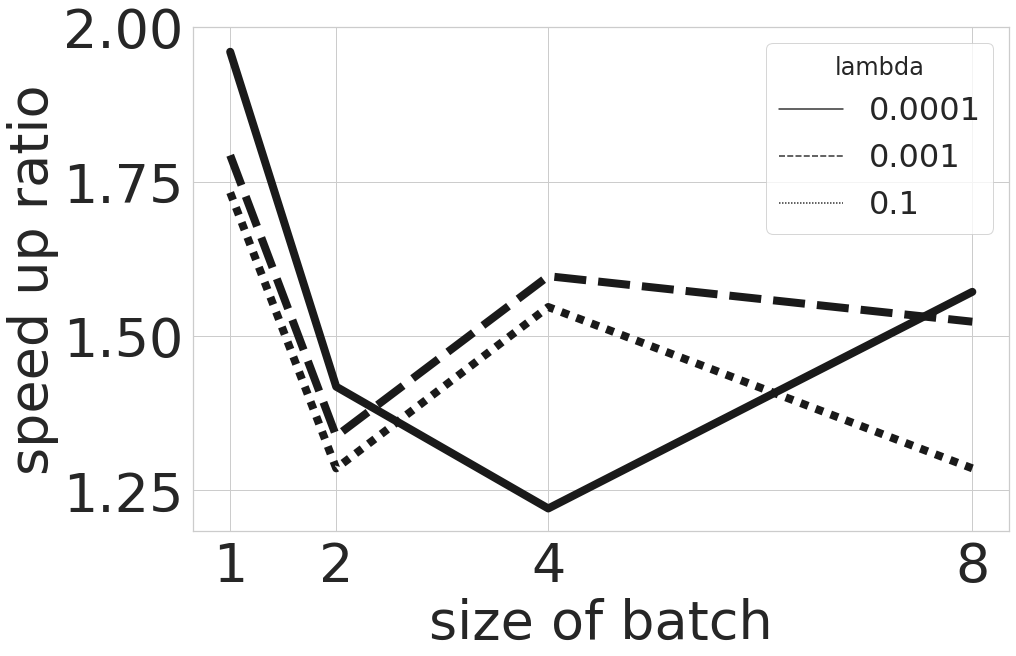

In [24]:
def _Draw_speed_batch_plot(sp_df, file):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
    matplotlib.rcParams['mathtext.fontset'] = 'cm'

    SMALL_SIZE = 25
    MEDIUM_SIZE = 32
    BIGGER_SIZE = 36

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=1.5*BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=1.5*BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)

    figure = plt.figure(figsize=(15,10))
    axes = figure.add_subplot (1, 1, 1)
    # axes.set_yscale('log', subsy = [2,4,6,8])
    # axes.set_xscale('log', basex = 2, subsx = [1,2,3,4,5,6,7,8,9])
    plt.xlabel('size of batch')
    plt.ylabel(r'speed up ratio')


    g = sns.lineplot(data=sp_df, y='ratio', x='batch_size', style="lambda", linewidth = 8)

    plt.setp(g.artists, edgecolor = 'k', facecolor='w')
    plt.setp(g.lines, color='k')
    axes.set_xticks([1, 2, 4, 8])
    axes.set_yticks([1.25, 1.5, 1.75, 2])

    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.savefig('speed_batch_size')
    plt.show()
    

def speed_batch_plot(data_file, plot_file):
    df = pd.read_csv(data_file)
    df.head()
    
    sp_df = get_speed(df)
    sp_df.ratio = 1/sp_df.ratio
    
    _Draw_speed_batch_plot(sp_df, plot_file)
    

speed_batch_plot('df10', 'plot_')

In [14]:
def _Draw_speed_lambda_plot(sp_df, file):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
    matplotlib.rcParams['mathtext.fontset'] = 'cm'

    SMALL_SIZE = 25
    MEDIUM_SIZE = 32
    BIGGER_SIZE = 36

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=1.5*BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=1.5*BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)

    figure = plt.figure(figsize=(15,10))
    axes = figure.add_subplot (1, 1, 1)
    # axes.set_yscale('log', subsy = [2,4,6,8])
    # axes.set_xscale('log', basex = 2, subsx = [1,2,3,4,5,6,7,8,9])
    plt.xlabel('lambda')
    plt.ylabel(r'speed up ratio')


    g = sns.lineplot(data=sp_df, y='ratio', x='lambda', style='batch_size', linewidth = 5)

    plt.setp(g.artists, edgecolor = 'k', facecolor='w')
    plt.setp(g.lines, color='k')
    # axes.set_xticks([1, 2, 4, 8])
    # axes.set_yticks([1.25, 1.5, 1.75, 2])
    # plt.ylim((None, 4))

    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.savefig(file)
    plt.show()
    

def speed_lambda_plot(data_file, batch_sizes, plot_file):
    df = pd.read_csv(data_file)
    df.head()
    
    sp_df = get_speed(df)
    sp_df.ratio = 1/sp_df.ratio
    
    flag = np.zeros(len(sp_df))
    for size in batch_sizes:
        flag = np.logical_or(flag, sp_df.batch_size == size)
    
    sp_df = sp_df[flag]
    _Draw_speed_lambda_plot(sp_df, plot_file)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

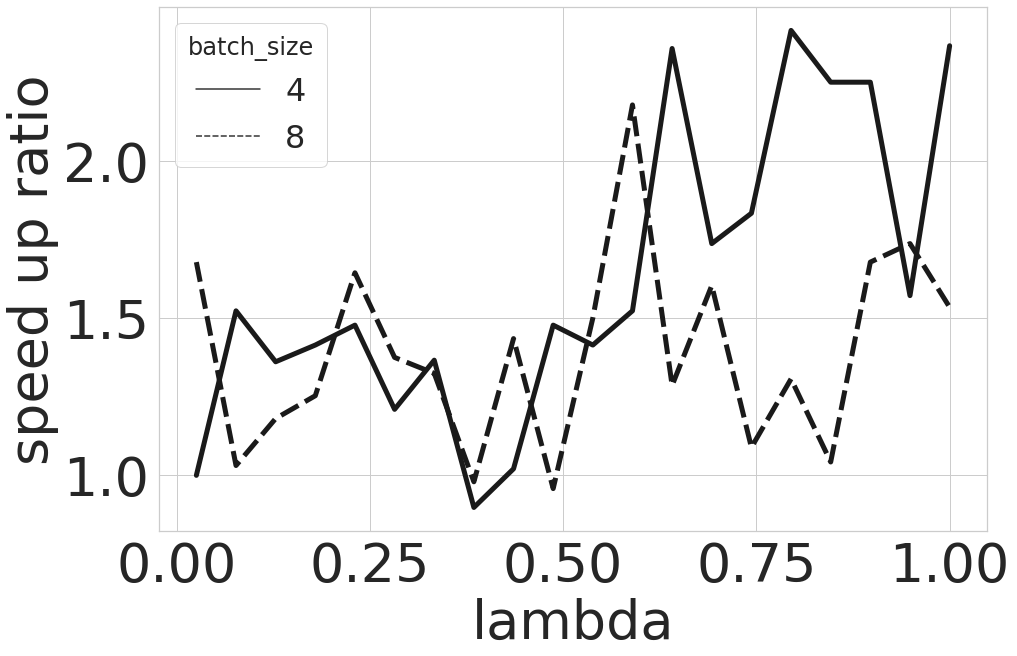

In [18]:
speed_lambda_plot('df_many', [4, 8], 'plot_')

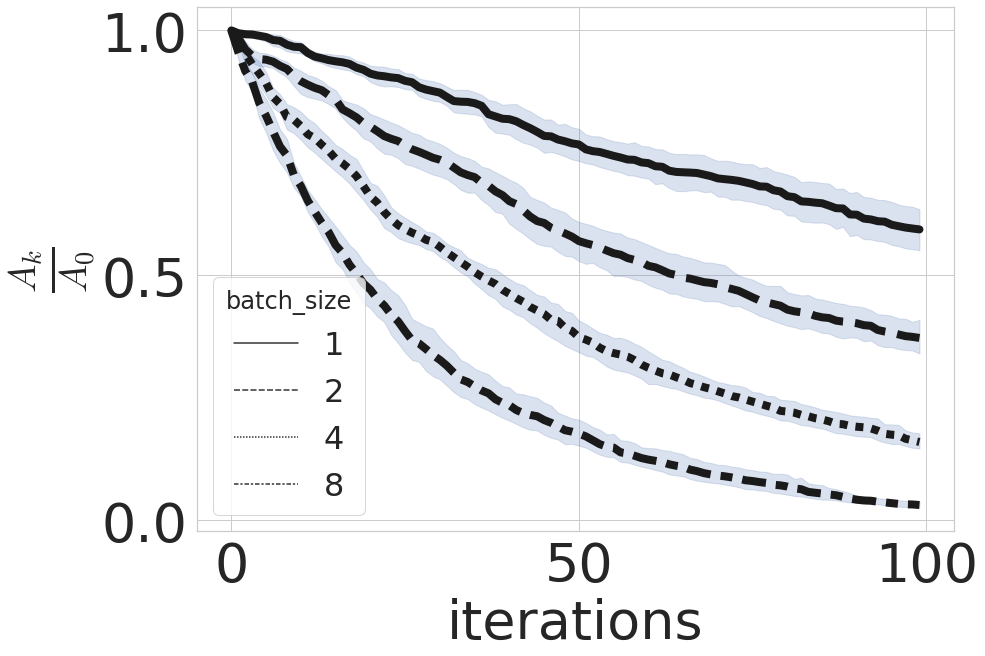

In [20]:
def _Draw_convergwnce_plot(conv_df, file):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
    matplotlib.rcParams['mathtext.fontset'] = 'cm'

    SMALL_SIZE = 25
    MEDIUM_SIZE = 32
    BIGGER_SIZE = 36

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=1.5*BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=1.5*BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=1.5*BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)

    figure = plt.figure(figsize=(15,10))
    axes = figure.add_subplot (1, 1, 1)
    # axes.set_yscale('log', subsy = [2,4,6,8])
    # axes.set_xscale('log', basex = 2, subsx = [1,2,3,4,5,6,7,8,9])
    plt.xlabel('iterations')
    plt.ylabel(r'$\frac{A_k}{A_0}$')


    g = sns.lineplot(data=conv_df, y='Ak/A0', x='iter', style="batch_size", linewidth = 8)

    plt.setp(g.artists, edgecolor = 'k', facecolor='w')
    plt.setp(g.lines, color='k')

    # axes.set_xticks([1, 2, 4, 8])
    # axes.set_yticks([1.25, 1.5, 1.75, 2])

    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.savefig(file)
    plt.show()
    

def convergwnce_plot(data_file, lambd, plot_file):
    df = pd.read_csv(data_file)
    df.head()
    
    conv_df = df[df['lambda'] == lambd]

    conv_df = conv_df[conv_df.sampling == 'conventional']

    _Draw_convergwnce_plot(conv_df, plot_file)

In [ ]:
convergwnce_plot('df10', 0.1, 'plot_')